## Experimentation with Privacy Tree: Reproducing Results from the Paper


This notebook provides a way to reproduce the experiment described in the paper [Privacy-Preserving Tree-Based Inference with Fully Homomorphic Encryption](https://arxiv.org/pdf/2303.01254.pdf). By following the instructions in this notebook, users can run the experiment themselves and verify the results reported in the paper.

In [1]:
import time

import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelBinarizer

from concrete.ml.sklearn import DecisionTreeClassifier, RandomForestClassifier, XGBClassifier

In [2]:
# Utils function


def basic_preprocessing(df, target_column):
    """Transform categorical values to one-hot."""
    categorical_columns = df.select_dtypes(include=["object", "category"]).columns
    df[categorical_columns] = df[categorical_columns].apply(
        lambda x: x.astype("category").cat.codes
    )
    df[target_column] = LabelBinarizer().fit_transform(df[target_column])
    return df

In [3]:
# Download the data-sets
datasets = {}
spambase = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data", header=None
)
spambase = basic_preprocessing(spambase, 57)
datasets["spambase"] = {"X": spambase.drop(57, axis=1).values, "y": spambase[57].values}

adults = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None
)
adults = basic_preprocessing(adults, 14)
datasets["adults"] = {"X": adults.drop(14, axis=1).values, "y": adults[14].values}

wine = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None
)
wine = basic_preprocessing(wine, 0)
datasets["wine"] = {"X": wine.drop(0, axis=1).values, "y": wine[0].values}

In [4]:
# Set the hyper-parameters and a seed for reproducibility
RANDOM_SEED = 42
MODELS = {
    DecisionTreeClassifier: {"max_depth": 5, "random_state": RANDOM_SEED},
    XGBClassifier: {"max_depth": 3, "n_estimators": 50, "random_state": RANDOM_SEED},
    RandomForestClassifier: {"n_estimators": 50, "random_state": RANDOM_SEED},
}
N_BITS_LIST = range(1, 9)

In [5]:
n_bits = 6
scores_global = {}

for dataset, data in datasets.items():
    rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    X, y = data["X"].astype(np.float32), data["y"]
    assert len(set(y)) == 2
    assert y.dtype in [int, bool]

    key_dataset = f"{dataset} (#features: {X.shape[1]})"
    scores_global[key_dataset] = {}

    for model, model_params in MODELS.items():
        clf = model(n_bits=n_bits, **model_params)
        concrete_model, sklearn_model = clf.fit_benchmark(X, y)
        scores_global[key_dataset][model.__name__ + "_concrete"] = {}
        scores_global[key_dataset][model.__name__ + "_fp32"] = {}
        concrete_scores, fp32_scores = {
            "precision": [],
            "recall": [],
            "accuracy": [],
            "f1": [],
            "average_precision": [],
        }, {"precision": [], "recall": [], "accuracy": [], "f1": [], "average_precision": []}
        for train_index, test_index in rkf.split(X):
            X_train_, X_test_ = X[train_index], X[test_index]
            y_train_, y_test_ = y[train_index], y[test_index]

            y_pred = concrete_model.predict(X_test_)
            concrete_scores["precision"].append(precision_score(y_test_, y_pred))
            concrete_scores["recall"].append(recall_score(y_test_, y_pred))
            concrete_scores["accuracy"].append(accuracy_score(y_test_, y_pred))
            concrete_scores["f1"].append(f1_score(y_test_, y_pred))
            concrete_scores["average_precision"].append(average_precision_score(y_test_, y_pred))

            y_pred = sklearn_model.predict(X_test_)
            fp32_scores["precision"].append(precision_score(y_test_, y_pred))
            fp32_scores["recall"].append(recall_score(y_test_, y_pred))
            fp32_scores["accuracy"].append(accuracy_score(y_test_, y_pred))
            fp32_scores["f1"].append(f1_score(y_test_, y_pred))
            fp32_scores["average_precision"].append(average_precision_score(y_test_, y_pred))

        if "fhe_inference_time" not in scores_global[key_dataset][model.__name__ + "_concrete"]:
            concrete_model.compile(X_train_)
            concrete_model.fhe_circuit.keygen(force=False)

            start = time.time()
            concrete_model.predict(X_test_[:1], fhe="execute")
            end = time.time()
            scores_global[key_dataset][model.__name__ + "_concrete"]["inference_time"] = end - start

            start = time.time()
            concrete_model.predict(X_test_[:1], fhe="disable")
            end = time.time()
            scores_global[key_dataset][model.__name__ + "_fp32"]["inference_time"] = end - start

        scores_global[key_dataset][model.__name__ + "_concrete"].update(concrete_scores)
        scores_global[key_dataset][model.__name__ + "_fp32"].update(fp32_scores)

        print("Average precision:", np.mean(concrete_scores["average_precision"]))
        print("Average precision (fp32):", np.mean(fp32_scores["average_precision"]))

Average precision: 0.8590584502269576
Average precision (fp32): 0.856742055225908
Average precision: 0.8859057196962661
Average precision (fp32): 0.8978489602543138
Average precision: 0.8533618889112272
Average precision (fp32): 0.8702812578992057
Average precision: 0.5257920855944928
Average precision (fp32): 0.5313028959377616
Average precision: 0.5311883185588149
Average precision (fp32): 0.5435889125308891
Average precision: 0.4736968702820955
Average precision (fp32): 0.4878108468555631
Average precision: 1.0
Average precision (fp32): 1.0
Average precision: 1.0
Average precision (fp32): 1.0
Average precision: 1.0
Average precision (fp32): 1.0


In [6]:
# Create an empty dictionary to store the results
results = {}

# Loop through the data-sets and models to extract the scores
for key_dataset, dataset_scores in scores_global.items():
    print(key_dataset)
    if key_dataset not in results:
        results[key_dataset] = {}
    for model in MODELS:
        results[key_dataset][model.__name__ + "_concrete"] = {}
        results[key_dataset][model.__name__ + "_fp32"] = {}
        for metric in ["precision", "recall", "accuracy", "f1", "average_precision"]:
            results[key_dataset][model.__name__ + "_concrete"][metric] = np.mean(
                dataset_scores[model.__name__ + "_concrete"][metric]
            )
            results[key_dataset][model.__name__ + "_fp32"][metric] = np.mean(
                dataset_scores[model.__name__ + "_fp32"][metric]
            )
        results[key_dataset][model.__name__ + "_concrete"]["inference_time"] = dataset_scores[
            model.__name__ + "_concrete"
        ]["inference_time"]
        results[key_dataset][model.__name__ + "_fp32"]["inference_time"] = dataset_scores[
            model.__name__ + "_fp32"
        ]["inference_time"]

# Create a pandas dataframe from the results dictionary
df = pd.DataFrame.from_dict(results, orient="index")
df = df.stack().apply(pd.Series).stack().unstack(2)
df.index.names = ["dataset", "model"]

# Display the dataframe
print(df)

spambase (#features: 57)
adults (#features: 14)
wine (#features: 13)
                                                          precision    recall  \
dataset                  model                                                  
spambase (#features: 57) DecisionTreeClassifier_concrete   0.943842  0.845676   
                         DecisionTreeClassifier_fp32       0.938935  0.849004   
                         XGBClassifier_concrete            0.953242  0.879400   
                         XGBClassifier_fp32                0.947141  0.910795   
                         RandomForestClassifier_concrete   0.955468  0.817996   
                         RandomForestClassifier_fp32       0.959677  0.841862   
adults (#features: 14)   DecisionTreeClassifier_concrete   0.781405  0.527056   
                         DecisionTreeClassifier_fp32       0.784114  0.534578   
                         XGBClassifier_concrete            0.795885  0.523122   
                         XGBClassifier_f

In [7]:
def calculate_scores(model, n_bits, X, y, rkf):
    """Calculates scores."""
    scores = {
        "precision": [],
        "recall": [],
        "accuracy": [],
        "f1": [],
        "average_precision": [],
        "fhe_inference_time": [],
    }
    scores_fp32 = {"precision": [], "recall": [], "accuracy": [], "f1": [], "average_precision": []}

    for train_index, test_index in rkf.split(X):
        X_train_, X_test_ = X[train_index], X[test_index]
        y_train_, y_test_ = y[train_index], y[test_index]

        # Train the model and benchmark it
        clf = model(n_bits=n_bits, **MODELS[model])
        concrete_model, sklearn_model = clf.fit_benchmark(X_train_, y_train_)

        # Make predictions and calculate scores
        y_pred = concrete_model.predict(X_test_)
        scores["precision"].append(precision_score(y_test_, y_pred))
        scores["recall"].append(recall_score(y_test_, y_pred))
        scores["accuracy"].append(accuracy_score(y_test_, y_pred))
        scores["f1"].append(f1_score(y_test_, y_pred))
        scores["average_precision"].append(average_precision_score(y_test_, y_pred))

        y_pred = sklearn_model.predict(X_test_)
        scores_fp32["precision"].append(precision_score(y_test_, y_pred))
        scores_fp32["recall"].append(recall_score(y_test_, y_pred))
        scores_fp32["accuracy"].append(accuracy_score(y_test_, y_pred))
        scores_fp32["f1"].append(f1_score(y_test_, y_pred))
        scores_fp32["average_precision"].append(average_precision_score(y_test_, y_pred))

    return {
        f"{model.__name__}_concrete": scores,
        f"{model.__name__}_fp32": scores_fp32,
    }


# Setup repeated k-fold cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
X, y = datasets["spambase"]["X"], datasets["spambase"]["y"]
X = X.astype(np.float32)
assert len(set(y)) == 2
assert y.dtype in [int, bool]

# Calculate scores for different models and n_bits
scores_global = {}
for n_bits in N_BITS_LIST:
    scores_global[n_bits] = {}
    for model in MODELS:
        print(f"Calculating scores for {model.__name__} with n_bits={n_bits}...")
        scores = calculate_scores(model, n_bits, X, y, rkf)
        scores_global[n_bits].update(scores)

Calculating scores for DecisionTreeClassifier with n_bits=1...
Calculating scores for XGBClassifier with n_bits=1...
Calculating scores for RandomForestClassifier with n_bits=1...
Calculating scores for DecisionTreeClassifier with n_bits=2...
Calculating scores for XGBClassifier with n_bits=2...
Calculating scores for RandomForestClassifier with n_bits=2...
Calculating scores for DecisionTreeClassifier with n_bits=3...
Calculating scores for XGBClassifier with n_bits=3...
Calculating scores for RandomForestClassifier with n_bits=3...
Calculating scores for DecisionTreeClassifier with n_bits=4...
Calculating scores for XGBClassifier with n_bits=4...
Calculating scores for RandomForestClassifier with n_bits=4...
Calculating scores for DecisionTreeClassifier with n_bits=5...
Calculating scores for XGBClassifier with n_bits=5...
Calculating scores for RandomForestClassifier with n_bits=5...
Calculating scores for DecisionTreeClassifier with n_bits=6...
Calculating scores for XGBClassifier 

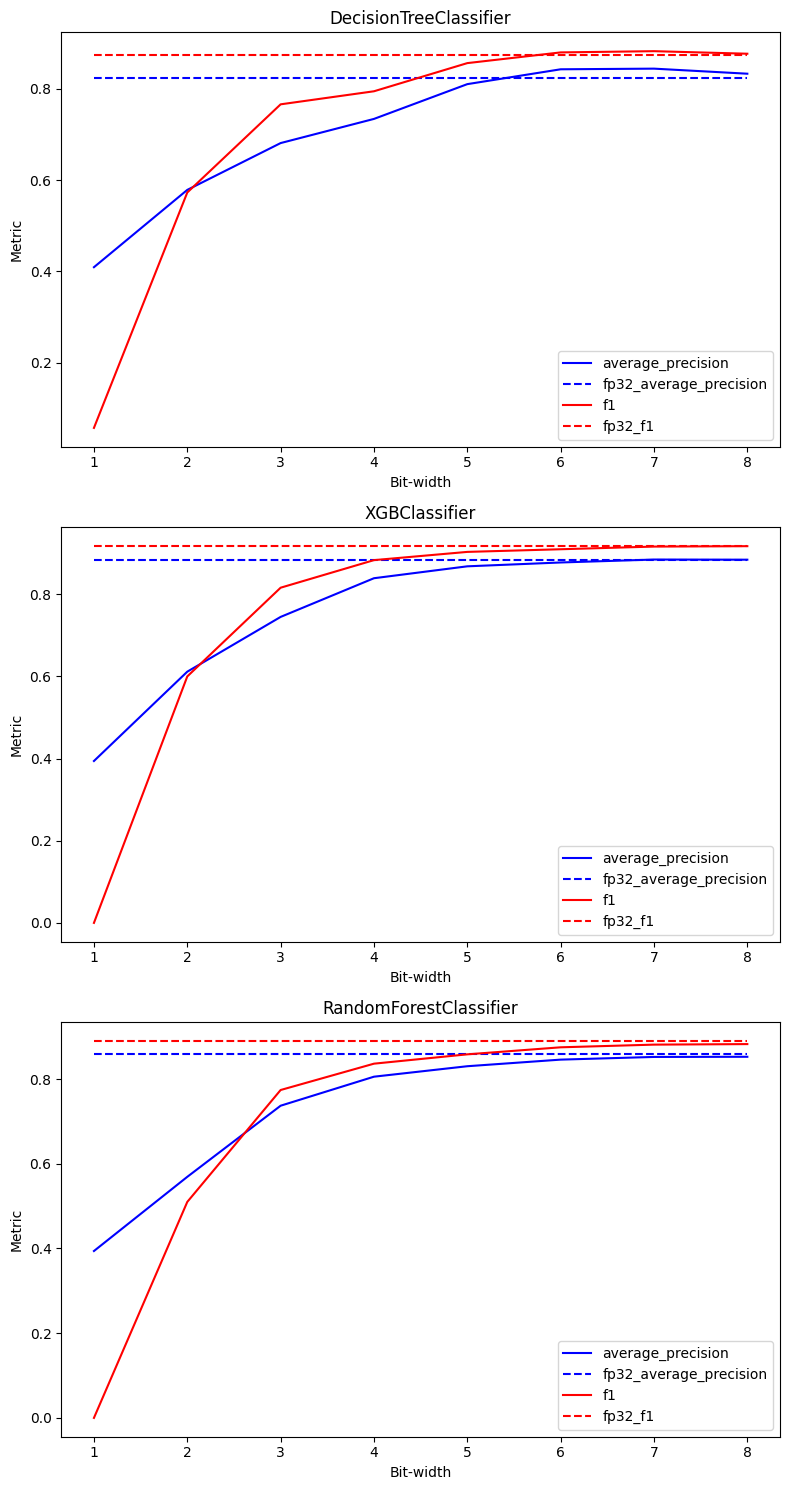

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=len(MODELS), ncols=1, figsize=(8, 5 * len(MODELS)))

for i, model in enumerate(MODELS):
    axs[i].set_title(model.__name__)
    axs[i].set_xlabel("Bit-width")
    axs[i].set_ylabel("Metric")

    ap_scores = [
        np.mean(scores_global[n_bits][f"{model.__name__}_{q}"]["average_precision"])
        for n_bits in N_BITS_LIST
        for q in ["concrete", "fp32"]
        if n_bits in scores_global and f"{model.__name__}_{q}" in scores_global[n_bits]
    ]
    f1_scores = [
        np.mean(scores_global[n_bits][f"{model.__name__}_{q}"]["f1"])
        for n_bits in N_BITS_LIST
        for q in ["concrete", "fp32"]
        if n_bits in scores_global and f"{model.__name__}_{q}" in scores_global[n_bits]
    ]

    axs[i].plot(N_BITS_LIST, ap_scores[::2], label="average_precision", color="blue")
    axs[i].plot(
        N_BITS_LIST,
        ap_scores[1::2],
        label="fp32_average_precision",
        color="blue",
        linestyle="dashed",
    )
    axs[i].plot(N_BITS_LIST, f1_scores[::2], label="f1", color="red")
    axs[i].plot(N_BITS_LIST, f1_scores[1::2], label="fp32_f1", color="red", linestyle="dashed")

    axs[i].legend()

fig.tight_layout()
fig.savefig("accuracy.png", bbox_inches="tight", dpi=300)
plt.show()

In [9]:
X, y = datasets["spambase"]["X"], datasets["spambase"]["y"]
scores = {model.__name__: [] for model in MODELS}

for n_bits in N_BITS_LIST:
    for model, model_params in MODELS.items():
        clf = model(n_bits=n_bits, **model_params)
        clf.fit(X, y)

        print(f"Compiling and keygen for {model.__name__} with {n_bits} bits...")
        clf.compile(X)
        clf.fhe_circuit.keygen(force=False)

        print("Predict in FHE")
        t0 = time.time()
        y_pred_ = clf.predict(X[:1], fhe="execute")
        t1 = time.time()
        print(f"FHE execution time: {t1-t0:.2f} seconds")
        scores[model.__name__].append(t1 - t0)
    print("\n")

Compiling and keygen for DecisionTreeClassifier with 1 bits...
Predict in FHE
FHE execution time: 0.29 seconds
Compiling and keygen for XGBClassifier with 1 bits...
Predict in FHE
FHE execution time: 0.01 seconds
Compiling and keygen for RandomForestClassifier with 1 bits...
Predict in FHE
FHE execution time: 0.38 seconds


Compiling and keygen for DecisionTreeClassifier with 2 bits...
Predict in FHE
FHE execution time: 0.26 seconds
Compiling and keygen for XGBClassifier with 2 bits...
Predict in FHE
FHE execution time: 0.32 seconds
Compiling and keygen for RandomForestClassifier with 2 bits...
Predict in FHE
FHE execution time: 0.46 seconds


Compiling and keygen for DecisionTreeClassifier with 3 bits...
Predict in FHE
FHE execution time: 0.16 seconds
Compiling and keygen for XGBClassifier with 3 bits...
Predict in FHE
FHE execution time: 0.24 seconds
Compiling and keygen for RandomForestClassifier with 3 bits...
Predict in FHE
FHE execution time: 0.52 seconds


Compiling and keygen f

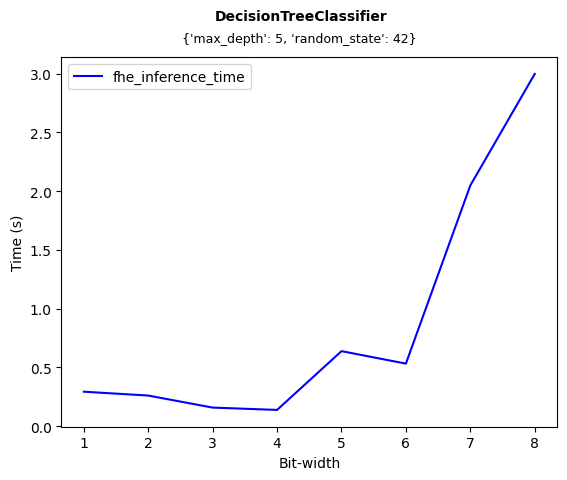

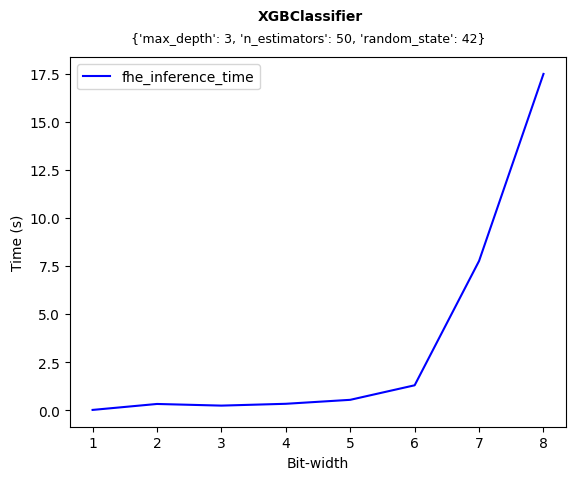

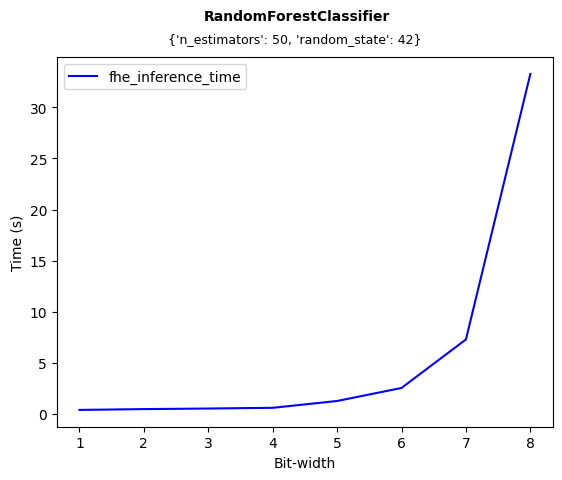

In [10]:
for model, model_params in MODELS.items():
    plt.figure()

    fhe_inference_times = scores[model.__name__]

    plt.plot(
        range(1, len(fhe_inference_times) + 1),
        fhe_inference_times,
        label="fhe_inference_time",
        color="blue",
    )
    plt.legend()

    plt.suptitle(model.__name__, fontsize=10, fontweight="bold")
    plt.annotate(model_params, xy=(0.48, 1.04), xycoords="axes fraction", fontsize=9, ha="center")
    plt.xlabel("Bit-width")
    plt.ylabel("Time (s)")

    plt.savefig(f"{model.__name__}_fhe_inference_time.png", bbox_inches="tight", dpi=300)
    plt.show()